In [1]:
from src.utils.utils import *
load_config_data = load_config("config.yaml") # Renamed to avoid conflict
print(load_config_data)
train_config = load_config_data.get("train", {})
set_all_seeds(load_config_data['SEED'])

base_dir = create_base_path()

valid_lr_image_dir_path = base_dir["root"] / "data\\processed\\Set5\\cubic_X4_pixels96_stride48\\valid\\lr"
valid_hr_image_dir_path = base_dir["root"] / "data\\raw\\Set5"

valid_lr_image_files = find_image_files(valid_lr_image_dir_path)
valid_hr_image_files = find_image_files(valid_hr_image_dir_path)


{'SEED': 42, 'train': {'model': 'SRCNN', 'benchmark': 'v1', 'train_image_dir': 'data\\processed\\DIV2K\\cubic_X4_pixels96_stride48\\train', 'valid_lr_image_dir': 'data\\processed\\Set5\\cubic_X4_pixels96_stride48\\valid\\lr', 'valid_hr_image_dir': 'data\\raw\\Set5', 'SRCNN': {'resume': 'models/srcnn_x2-T91-7d6e0623.pth.tar', 'parameters': {'f1': 9, 'f2': 1, 'f3': 5, 'n1': 64, 'n2': 32, 'pad1': 4, 'pad2': 0, 'pad3': 2}, 'epochs': 1, 'batch_size': 64, 'model_lr': '1e-4', 'model_momentum': 0.9, 'model_weight_decay': '1e-4', 'model_nesterov': False}, 'SRGAN': {'resume': 'models/srgan_x2-T91-7d6e0623.pth.tar', 'parameters': {'epochs': 58000}, 'epochs': 1, 'batch_size': 64, 'model_lr': '1e-4', 'model_momentum': 0.9, 'model_weight_decay': '1e-4', 'model_nesterov': False}}, 'evaluate': {'lr_dir': 'data/Set5/GTmod12', 'sr_dir': 'results/test/SRCNN', 'hr_dir': 'data/Set5/GTmod12', 'model_path': 'results/pretrained_models/srcnn_x2-T91-7d6e0623.pth.tar'}}


In [6]:
import os
import time
import cv2
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from src.utils.utils import *

class ImageSuperResolutionDataset(Dataset):
    def __init__(self, lr_image_files, hr_image_files, mode='train'):
        if len(lr_image_files) != len(hr_image_files):
            raise ValueError("LR and HR image file lists must have the same length.")
        self.lr_image_files = lr_image_files
        self.hr_image_files = hr_image_files

    def __len__(self):
        return len(self.lr_image_files)

    def __getitem__(self, idx):
        lr_image_path = self.lr_image_files[idx]
        hr_image_path = self.hr_image_files[idx]

        lr_image = cv2.imread(lr_image_path, cv2.IMREAD_UNCHANGED)
        hr_image = cv2.imread(hr_image_path, cv2.IMREAD_UNCHANGED)
        
        if lr_image is None:
            print(f"Warning: Could not read LR image: {lr_image_path}. Skipping.")
            return None # Or handle error appropriately
        if hr_image is None:
            print(f"Warning: Could not read HR image: {hr_image_path}. Skipping.")
            return None # Or handle error appropriately

        lr_image = lr_image.astype(np.float32) / 255.
        hr_image = hr_image.astype(np.float32) / 255.

        h_hr, w_hr = hr_image.shape[:2]
        # Resize LR to HR dimensions using the scale factor to match what SRCNN often expects
        lr_resized_for_srcnn_input = cv2.resize(lr_image, (w_hr, h_hr), interpolation=cv2.INTER_CUBIC)

        lr_y_image = bgr2ycbcr(lr_resized_for_srcnn_input, only_use_y_channel=True)
        hr_y_image = bgr2ycbcr(hr_image, only_use_y_channel=True)

        # Convert image data into Tensor stream format (PyTorch).
        # Note: The range of input and output is between [0, 1]
        lr_y_tensor = to_tensor(lr_y_image, range_norm=False, half=False)
        hr_y_tensor = to_tensor(hr_y_image, range_norm=False, half=False)

        return lr_y_tensor, hr_y_tensor
    

def prepare_data():

    # Assume you have test_lr_image_files and test_hr_image_files
    valid_dataset = ImageSuperResolutionDataset(
        lr_image_files=valid_lr_image_files,
        hr_image_files=valid_hr_image_files
    )
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)
    return {
        "valid_loader": valid_loader
    }

In [34]:
# Copyright 2022 Dakewe Biotech Corporation. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import math
import random
from typing import Any

import cv2
import numpy as np
import torch
from torchvision.transforms import functional as F

__all__ = [
    "image2tensor", "tensor2image",
    "image_resize",
    "expand_y", "rgb2ycbcr", "bgr2ycbcr", "ycbcr2bgr", "ycbcr2rgb",
    "rgb2ycbcr_torch", "bgr2ycbcr_torch",
    "center_crop", "random_crop", "random_rotate", "random_vertically_flip", "random_horizontally_flip",
]


def image2tensor(image: np.ndarray, range_norm: bool, half: bool) -> torch.Tensor:
    """Convert the image data type to the Tensor (NCWH) data type supported by PyTorch

    Args:
        image (np.ndarray): The image data read by ``OpenCV.imread``, the data range is [0,255] or [0, 1]
        range_norm (bool): Scale [0, 1] data to between [-1, 1]
        half (bool): Whether to convert torch.float32 similarly to torch.half type

    Returns:
        tensor (torch.Tensor): Data types supported by PyTorch

    Examples:
        >>> example_image = cv2.imread("lr_image.bmp")
        >>> example_tensor = image2tensor(example_image, range_norm=True, half=False)

    """
    # Convert image data type to Tensor data type
    tensor = F.to_tensor(image)

    # Scale the image data from [0, 1] to [-1, 1]
    if range_norm:
        tensor = tensor.mul(2.0).sub(1.0)

    # Convert torch.float32 image data type to torch.half image data type
    if half:
        tensor = tensor.half()

    return tensor


def tensor2image(tensor: torch.Tensor, range_norm: bool, half: bool) -> Any:
    """Convert the Tensor(NCWH) data type supported by PyTorch to the np.ndarray(WHC) image data type

    Args:
        tensor (torch.Tensor): Data types supported by PyTorch (NCHW), the data range is [0, 1]
        range_norm (bool): Scale [-1, 1] data to between [0, 1]
        half (bool): Whether to convert torch.float32 similarly to torch.half type.

    Returns:
        image (np.ndarray): Data types supported by PIL or OpenCV

    Examples:
        >>> example_image = cv2.imread("lr_image.bmp")
        >>> example_tensor = image2tensor(example_image, range_norm=False, half=False)

    """
    if range_norm:
        tensor = tensor.add(1.0).div(2.0)
    if half:
        tensor = tensor.half()

    image = tensor.squeeze(0).permute(1, 2, 0).mul(255).clamp(0, 255).cpu().numpy().astype("uint8")

    return image


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def _cubic(x: Any) -> Any:
    """Implementation of `cubic` function in Matlab under Python language.

    Args:
        x: Element vector.

    Returns:
        Bicubic interpolation

    """
    absx = torch.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * ((absx <= 1).type_as(absx)) + (
            -0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * (
               ((absx > 1) * (absx <= 2)).type_as(absx))


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def _calculate_weights_indices(in_length: int,
                               out_length: int,
                               scale: float,
                               kernel_width: int,
                               antialiasing: bool) -> [np.ndarray, np.ndarray, int, int]:
    """Implementation of `calculate_weights_indices` function in Matlab under Python language.

    Args:
        in_length (int): Input length.
        out_length (int): Output length.
        scale (float): Scale factor.
        kernel_width (int): Kernel width.
        antialiasing (bool): Whether to apply antialiasing when down-sampling operations.
            Caution: Bicubic down-sampling in PIL uses antialiasing by default.

    Returns:
       weights, indices, sym_len_s, sym_len_e

    """
    if (scale < 1) and antialiasing:
        # Use a modified kernel (larger kernel width) to simultaneously
        # interpolate and antialiasing
        kernel_width = kernel_width / scale

    # Output-space coordinates
    x = torch.linspace(1, out_length, out_length)

    # Input-space coordinates. Calculate the inverse mapping such that 0.5
    # in output space maps to 0.5 in input space, and 0.5 + scale in output
    # space maps to 1.5 in input space.
    u = x / scale + 0.5 * (1 - 1 / scale)

    # What is the left-most pixel that can be involved in the computation?
    left = torch.floor(u - kernel_width / 2)

    # What is the maximum number of pixels that can be involved in the
    # computation?  Note: it's OK to use an extra pixel here; if the
    # corresponding weights are all zero, it will be eliminated at the end
    # of this function.
    p = math.ceil(kernel_width) + 2

    # The indices of the input pixels involved in computing the k-th output
    # pixel are in row k of the indices matrix.
    indices = left.view(out_length, 1).expand(out_length, p) + torch.linspace(0, p - 1, p).view(1, p).expand(
        out_length, p)

    # The weights used to compute the k-th output pixel are in row k of the
    # weights matrix.
    distance_to_center = u.view(out_length, 1).expand(out_length, p) - indices

    # apply cubic kernel
    if (scale < 1) and antialiasing:
        weights = scale * _cubic(distance_to_center * scale)
    else:
        weights = _cubic(distance_to_center)

    # Normalize the weights matrix so that each row sums to 1.
    weights_sum = torch.sum(weights, 1).view(out_length, 1)
    weights = weights / weights_sum.expand(out_length, p)

    # If a column in weights is all zero, get rid of it. only consider the
    # first and last column.
    weights_zero_tmp = torch.sum((weights == 0), 0)
    if not math.isclose(weights_zero_tmp[0], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 1, p - 2)
        weights = weights.narrow(1, 1, p - 2)
    if not math.isclose(weights_zero_tmp[-1], 0, rel_tol=1e-6):
        indices = indices.narrow(1, 0, p - 2)
        weights = weights.narrow(1, 0, p - 2)
    weights = weights.contiguous()
    indices = indices.contiguous()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def image_resize(image: Any, scale_factor: float, antialiasing: bool = True) -> Any:
    """Implementation of `imresize` function in Matlab under Python language.

    Args:
        image: The input image.
        scale_factor (float): Scale factor. The same scale applies for both height and width.
        antialiasing (bool): Whether to apply antialiasing when down-sampling operations.
            Caution: Bicubic down-sampling in `PIL` uses antialiasing by default. Default: ``True``.

    Returns:
        out_2 (np.ndarray): Output image with shape (c, h, w), [0, 1] range, w/o round

    """
    squeeze_flag = False
    if type(image).__module__ == np.__name__:  # numpy type
        numpy_type = True
        if image.ndim == 2:
            image = image[:, :, None]
            squeeze_flag = True
        image = torch.from_numpy(image.transpose(2, 0, 1)).float()
    else:
        numpy_type = False
        if image.ndim == 2:
            image = image.unsqueeze(0)
            squeeze_flag = True

    in_c, in_h, in_w = image.size()
    out_h, out_w = math.ceil(in_h * scale_factor), math.ceil(in_w * scale_factor)
    kernel_width = 4

    # get weights and indices
    weights_h, indices_h, sym_len_hs, sym_len_he = _calculate_weights_indices(in_h, out_h, scale_factor, kernel_width,
                                                                              antialiasing)
    weights_w, indices_w, sym_len_ws, sym_len_we = _calculate_weights_indices(in_w, out_w, scale_factor, kernel_width,
                                                                              antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = torch.FloatTensor(in_c, in_h + sym_len_hs + sym_len_he, in_w)
    img_aug.narrow(1, sym_len_hs, in_h).copy_(image)

    sym_patch = image[:, :sym_len_hs, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, 0, sym_len_hs).copy_(sym_patch_inv)

    sym_patch = image[:, -sym_len_he:, :]
    inv_idx = torch.arange(sym_patch.size(1) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(1, inv_idx)
    img_aug.narrow(1, sym_len_hs + in_h, sym_len_he).copy_(sym_patch_inv)

    out_1 = torch.FloatTensor(in_c, out_h, in_w)
    kernel_width = weights_h.size(1)
    for i in range(out_h):
        idx = int(indices_h[i][0])
        for j in range(in_c):
            out_1[j, i, :] = img_aug[j, idx:idx + kernel_width, :].transpose(0, 1).mv(weights_h[i])

    # process W dimension
    # symmetric copying
    out_1_aug = torch.FloatTensor(in_c, out_h, in_w + sym_len_ws + sym_len_we)
    out_1_aug.narrow(2, sym_len_ws, in_w).copy_(out_1)

    sym_patch = out_1[:, :, :sym_len_ws]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, 0, sym_len_ws).copy_(sym_patch_inv)

    sym_patch = out_1[:, :, -sym_len_we:]
    inv_idx = torch.arange(sym_patch.size(2) - 1, -1, -1).long()
    sym_patch_inv = sym_patch.index_select(2, inv_idx)
    out_1_aug.narrow(2, sym_len_ws + in_w, sym_len_we).copy_(sym_patch_inv)

    out_2 = torch.FloatTensor(in_c, out_h, out_w)
    kernel_width = weights_w.size(1)
    for i in range(out_w):
        idx = int(indices_w[i][0])
        for j in range(in_c):
            out_2[j, :, i] = out_1_aug[j, :, idx:idx + kernel_width].mv(weights_w[i])

    if squeeze_flag:
        out_2 = out_2.squeeze(0)
    if numpy_type:
        out_2 = out_2.numpy()
        if not squeeze_flag:
            out_2 = out_2.transpose(1, 2, 0)

    return out_2


def expand_y(image: np.ndarray) -> np.ndarray:
    """Convert BGR channel to YCbCr format,
    and expand Y channel data in YCbCr, from HW to HWC

    Args:
        image (np.ndarray): Y channel image data

    Returns:
        y_image (np.ndarray): Y-channel image data in HWC form

    """
    # Normalize image data to [0, 1]
    image = image.astype(np.float32) / 255.

    # Convert BGR to YCbCr, and extract only Y channel
    y_image = bgr2ycbcr(image, only_use_y_channel=True)

    # Expand Y channel
    y_image = y_image[..., None]

    # Normalize the image data to [0, 255]
    y_image = y_image.astype(np.float64) * 255.0

    return y_image


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def rgb2ycbcr(image: np.ndarray, only_use_y_channel: bool) -> np.ndarray:
    """Implementation of rgb2ycbcr function in Matlab under Python language

    Args:
        image (np.ndarray): Image input in RGB format.
        only_use_y_channel (bool): Extract Y channel separately

    Returns:
        image (np.ndarray): YCbCr image array data

    """
    if only_use_y_channel:
        image = np.dot(image, [65.481, 128.553, 24.966]) + 16.0
    else:
        image = np.matmul(image, [[65.481, -37.797, 112.0], [128.553, -74.203, -93.786], [24.966, 112.0, -18.214]]) + [
            16, 128, 128]

    image /= 255.
    image = image.astype(np.float32)

    return image


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def bgr2ycbcr(image: np.ndarray, only_use_y_channel: bool) -> np.ndarray:
    """Implementation of bgr2ycbcr function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in BGR format
        only_use_y_channel (bool): Extract Y channel separately

    Returns:
        image (np.ndarray): YCbCr image array data

    """
    if only_use_y_channel:
        image = np.dot(image, [24.966, 128.553, 65.481]) + 16.0
    else:
        image = np.matmul(image, [[24.966, 112.0, -18.214], [128.553, -74.203, -93.786], [65.481, -37.797, 112.0]]) + [
            16, 128, 128]

    image /= 255.
    image = image.astype(np.float32)

    return image


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def ycbcr2rgb(image: np.ndarray) -> np.ndarray:
    """Implementation of ycbcr2rgb function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in YCbCr format.

    Returns:
        image (np.ndarray): RGB image array data

    """
    image_dtype = image.dtype
    image *= 255.

    image = np.matmul(image, [[0.00456621, 0.00456621, 0.00456621],
                              [0, -0.00153632, 0.00791071],
                              [0.00625893, -0.00318811, 0]]) * 255.0 + [-222.921, 135.576, -276.836]

    image /= 255.
    image = image.astype(image_dtype)

    return image


# Code reference `https://github.com/xinntao/BasicSR/blob/master/basicsr/utils/matlab_functions.py`
def ycbcr2bgr(image: np.ndarray) -> np.ndarray:
    """Implementation of ycbcr2bgr function in Matlab under Python language.

    Args:
        image (np.ndarray): Image input in YCbCr format.

    Returns:
        image (np.ndarray): BGR image array data

    """
    image_dtype = image.dtype
    image *= 255.

    image = np.matmul(image, [[0.00456621, 0.00456621, 0.00456621],
                              [0.00791071, -0.00153632, 0],
                              [0, -0.00318811, 0.00625893]]) * 255.0 + [-276.836, 135.576, -222.921]

    image /= 255.
    image = image.astype(image_dtype)

    return image


def rgb2ycbcr_torch(tensor: torch.Tensor, only_use_y_channel: bool) -> torch.Tensor:
    """Implementation of rgb2ycbcr function in Matlab under PyTorch

    References from：`https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion`

    Args:
        tensor (torch.Tensor): Image data in PyTorch format
        only_use_y_channel (bool): Extract only Y channel

    Returns:
        tensor (torch.Tensor): YCbCr image data in PyTorch format

    """
    if only_use_y_channel:
        weight = torch.Tensor([[65.481], [128.553], [24.966]]).to(tensor)
        tensor = torch.matmul(tensor.permute(0, 2, 3, 1), weight).permute(0, 3, 1, 2) + 16.0
    else:
        weight = torch.Tensor([[65.481, -37.797, 112.0],
                               [128.553, -74.203, -93.786],
                               [24.966, 112.0, -18.214]]).to(tensor)
        bias = torch.Tensor([16, 128, 128]).view(1, 3, 1, 1).to(tensor)
        tensor = torch.matmul(tensor.permute(0, 2, 3, 1), weight).permute(0, 3, 1, 2) + bias

    tensor /= 255.

    return tensor


def bgr2ycbcr_torch(tensor: torch.Tensor, only_use_y_channel: bool) -> torch.Tensor:
    """Implementation of bgr2ycbcr function in Matlab under PyTorch

    References from：`https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.601_conversion`

    Args:
        tensor (torch.Tensor): Image data in PyTorch format
        only_use_y_channel (bool): Extract only Y channel

    Returns:
        tensor (torch.Tensor): YCbCr image data in PyTorch format

    """
    if only_use_y_channel:
        weight = torch.Tensor([[24.966], [128.553], [65.481]]).to(tensor)
        tensor = torch.matmul(tensor.permute(0, 2, 3, 1), weight).permute(0, 3, 1, 2) + 16.0
    else:
        weight = torch.Tensor([[24.966, 112.0, -18.214],
                               [128.553, -74.203, -93.786],
                               [65.481, -37.797, 112.0]]).to(tensor)
        bias = torch.Tensor([16, 128, 128]).view(1, 3, 1, 1).to(tensor)
        tensor = torch.matmul(tensor.permute(0, 2, 3, 1), weight).permute(0, 3, 1, 2) + bias

    tensor /= 255.

    return tensor


def center_crop(image: np.ndarray, image_size: int) -> np.ndarray:
    """Crop small image patches from one image center area.

    Args:
        image (np.ndarray): The input image for `OpenCV.imread`.
        image_size (int): The size of the captured image area.

    Returns:
        patch_image (np.ndarray): Small patch image

    """
    image_height, image_width = image.shape[:2]

    # Just need to find the top and left coordinates of the image
    top = (image_height - image_size) // 2
    left = (image_width - image_size) // 2

    # Crop image patch
    patch_image = image[top:top + image_size, left:left + image_size, ...]

    return patch_image


def random_crop(image: np.ndarray, image_size: int) -> np.ndarray:
    """Crop small image patches from one image.

    Args:
        image (np.ndarray): The input image for `OpenCV.imread`.
        image_size (int): The size of the captured image area.

    Returns:
        patch_image (np.ndarray): Small patch image

    """
    image_height, image_width = image.shape[:2]

    # Just need to find the top and left coordinates of the image
    top = random.randint(0, image_height - image_size)
    left = random.randint(0, image_width - image_size)

    # Crop image patch
    patch_image = image[top:top + image_size, left:left + image_size, ...]

    return patch_image


def random_rotate(image,
                  angles: list,
                  center: tuple[int, int] = None,
                  scale_factor: float = 1.0) -> np.ndarray:
    """Rotate an image by a random angle

    Args:
        image (np.ndarray): Image read with OpenCV
        angles (list): Rotation angle range
        center (optional, tuple[int, int]): High resolution image selection center point. Default: ``None``
        scale_factor (optional, float): scaling factor. Default: 1.0

    Returns:
        rotated_image (np.ndarray): image after rotation

    """
    image_height, image_width = image.shape[:2]

    if center is None:
        center = (image_width // 2, image_height // 2)

    # Random select specific angle
    angle = random.choice(angles)
    matrix = cv2.getRotationMatrix2D(center, angle, scale_factor)
    rotated_image = cv2.warpAffine(image, matrix, (image_width, image_height))

    return rotated_image


def random_horizontally_flip(image: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Flip the image upside down randomly

    Args:
        image (np.ndarray): Image read with OpenCV
        p (optional, float): Horizontally flip probability. Default: 0.5

    Returns:
        horizontally_flip_image (np.ndarray): image after horizontally flip

    """
    if random.random() < p:
        horizontally_flip_image = cv2.flip(image, 1)
    else:
        horizontally_flip_image = image

    return horizontally_flip_image


def random_vertically_flip(image: np.ndarray, p: float = 0.5) -> np.ndarray:
    """Flip an image horizontally randomly

    Args:
        image (np.ndarray): Image read with OpenCV
        p (optional, float): Vertically flip probability. Default: 0.5

    Returns:
        vertically_flip_image (np.ndarray): image after vertically flip

    """
    if random.random() < p:
        vertically_flip_image = cv2.flip(image, 0)
    else:
        vertically_flip_image = image

    return vertically_flip_image

In [35]:
# Copyright 2022 Dakewe Biotech Corporation. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import warnings

import cv2
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

__all__ = [
    "psnr", "ssim",
    "PSNR", "SSIM",
]


# The following is the implementation of IQA method in Python, using CPU as processing device
def _check_image(raw_image: np.ndarray, dst_image: np.ndarray):
    """Check whether the size and type of the two images are the same

    Args:
        raw_image (np.ndarray): image data to be compared, BGR format, data range [0, 255]
        dst_image (np.ndarray): reference image data, BGR format, data range [0, 255]

    """
    # check image scale
    assert raw_image.shape == dst_image.shape, \
        f"Supplied images have different sizes {str(raw_image.shape)} and {str(dst_image.shape)}"

    # check image type
    if raw_image.dtype != dst_image.dtype:
        warnings.warn(f"Supplied images have different dtypes{str(raw_image.shape)} and {str(dst_image.shape)}")


def psnr(raw_image: np.ndarray, dst_image: np.ndarray, crop_border: int, only_test_y_channel: bool) -> float:
    """Python implements PSNR (Peak Signal-to-Noise Ratio, peak signal-to-noise ratio) function

    Args:
        raw_image (np.ndarray): image data to be compared, BGR format, data range [0, 255]
        dst_image (np.ndarray): reference image data, BGR format, data range [0, 255]
        crop_border (int): crop border a few pixels
        only_test_y_channel (bool): Whether to test only the Y channel of the image.

    Returns:
        psnr_metrics (np.float64): PSNR metrics

    """
    # Check if two images are similar in scale and type
    _check_image(raw_image, dst_image)

    # crop border pixels
    if crop_border > 0:
        raw_image = raw_image[crop_border:-crop_border, crop_border:-crop_border, ...]
        dst_image = dst_image[crop_border:-crop_border, crop_border:-crop_border, ...]

    # If you only test the Y channel, you need to extract the Y channel data of the YCbCr channel data separately
    if only_test_y_channel:
        raw_image = imgproc.expand_y(raw_image)
        dst_image = imgproc.expand_y(dst_image)

    # Convert data type to numpy.float64 bit
    raw_image = raw_image.astype(np.float64)
    dst_image = dst_image.astype(np.float64)

    psnr_metrics = 10 * np.log10((255.0 ** 2) / np.mean((raw_image - dst_image) ** 2) + 1e-8)

    return psnr_metrics


def _ssim(raw_image: np.ndarray, dst_image: np.ndarray) -> float:
    """Python implements the SSIM (Structural Similarity) function, which only calculates single-channel data

    Args:
        raw_image (np.ndarray): The image data to be compared, in BGR format, the data range is [0, 255]
        dst_image (np.ndarray): reference image data, BGR format, data range is [0, 255]

    Returns:
        ssim_metrics (float): SSIM metrics for single channel

    """
    c1 = (0.01 * 255.0) ** 2
    c2 = (0.03 * 255.0) ** 2

    kernel = cv2.getGaussianKernel(11, 1.5)
    kernel_window = np.outer(kernel, kernel.transpose())

    raw_mean = cv2.filter2D(raw_image, -1, kernel_window)[5:-5, 5:-5]
    dst_mean = cv2.filter2D(dst_image, -1, kernel_window)[5:-5, 5:-5]
    raw_mean_square = raw_mean ** 2
    dst_mean_square = dst_mean ** 2
    raw_dst_mean = raw_mean * dst_mean
    raw_variance = cv2.filter2D(raw_image ** 2, -1, kernel_window)[5:-5, 5:-5] - raw_mean_square
    dst_variance = cv2.filter2D(dst_image ** 2, -1, kernel_window)[5:-5, 5:-5] - dst_mean_square
    raw_dst_covariance = cv2.filter2D(raw_image * dst_image, -1, kernel_window)[5:-5, 5:-5] - raw_dst_mean

    ssim_molecular = (2 * raw_dst_mean + c1) * (2 * raw_dst_covariance + c2)
    ssim_denominator = (raw_mean_square + dst_mean_square + c1) * (raw_variance + dst_variance + c2)

    ssim_metrics = ssim_molecular / ssim_denominator
    ssim_metrics = np.mean(ssim_metrics)

    return ssim_metrics


def ssim(raw_image: np.ndarray, dst_image: np.ndarray, crop_border: int, only_test_y_channel: bool) -> float:
    """Python implements the SSIM (Structural Similarity) function, which calculates single/multi-channel data

    Args:
        raw_image (np.ndarray): The image data to be compared, in BGR format, the data range is [0, 255]
        dst_image (np.ndarray): reference image data, BGR format, data range is [0, 255]
        crop_border (int): crop border a few pixels
        only_test_y_channel (bool): Whether to test only the Y channel of the image

    Returns:
        ssim_metrics (float): SSIM metrics for single channel

    """
    # Check if two images are similar in scale and type
    _check_image(raw_image, dst_image)

    # crop border pixels
    if crop_border > 0:
        raw_image = raw_image[crop_border:-crop_border, crop_border:-crop_border, ...]
        dst_image = dst_image[crop_border:-crop_border, crop_border:-crop_border, ...]

    # If you only test the Y channel, you need to extract the Y channel data of the YCbCr channel data separately
    if only_test_y_channel:
        raw_image = imgproc.expand_y(raw_image)
        dst_image = imgproc.expand_y(dst_image)

    # Convert data type to numpy.float64 bit
    raw_image = raw_image.astype(np.float64)
    dst_image = dst_image.astype(np.float64)

    channels_ssim_metrics = []
    for channel in range(raw_image.shape[2]):
        ssim_metrics = _ssim(raw_image[..., channel], dst_image[..., channel])
        channels_ssim_metrics.append(ssim_metrics)
    ssim_metrics = np.mean(np.asarray(channels_ssim_metrics))

    return ssim_metrics


# The following is the IQA method implemented by PyTorch, using CUDA as the processing device
def _check_tensor_shape(raw_tensor: torch.Tensor, dst_tensor: torch.Tensor):
    """Check if the dimensions of the two tensors are the same

    Args:
        raw_tensor (np.ndarray or torch.Tensor): image tensor flow to be compared, RGB format, data range [0, 1]
        dst_tensor (np.ndarray or torch.Tensor): reference image tensorflow, RGB format, data range [0, 1]

    """
    # Check if tensor scales are consistent
    assert raw_tensor.shape == dst_tensor.shape, \
        f"Supplied images have different sizes {str(raw_tensor.shape)} and {str(dst_tensor.shape)}"


def _psnr_torch(raw_tensor: torch.Tensor, dst_tensor: torch.Tensor, crop_border: int,
                only_test_y_channel: bool) -> float:
    """PyTorch implements PSNR (Peak Signal-to-Noise Ratio, peak signal-to-noise ratio) function

    Args:
        raw_tensor (torch.Tensor): image tensor flow to be compared, RGB format, data range [0, 1]
        dst_tensor (torch.Tensor): reference image tensorflow, RGB format, data range [0, 1]
        crop_border (int): crop border a few pixels
        only_test_y_channel (bool): Whether to test only the Y channel of the image

    Returns:
        psnr_metrics (torch.Tensor): PSNR metrics

    """
    # Check if two tensor scales are similar
    _check_tensor_shape(raw_tensor, dst_tensor)

    # crop border pixels
    if crop_border > 0:
        raw_tensor = raw_tensor[:, :, crop_border:-crop_border, crop_border:-crop_border]
        dst_tensor = dst_tensor[:, :, crop_border:-crop_border, crop_border:-crop_border]

    # Convert RGB tensor data to YCbCr tensor, and extract only Y channel data
    if only_test_y_channel:
        raw_tensor = imgproc.rgb2ycbcr_torch(raw_tensor, only_use_y_channel=True)
        dst_tensor = imgproc.rgb2ycbcr_torch(dst_tensor, only_use_y_channel=True)

    # Convert data type to torch.float64 bit
    raw_tensor = raw_tensor.to(torch.float64)
    dst_tensor = dst_tensor.to(torch.float64)

    mse_value = torch.mean((raw_tensor * 255.0 - dst_tensor * 255.0) ** 2 + 1e-8, dim=[1, 2, 3])
    psnr_metrics = 10 * torch.log10_(255.0 ** 2 / mse_value)

    return psnr_metrics


class PSNR(nn.Module):
    """PyTorch implements PSNR (Peak Signal-to-Noise Ratio, peak signal-to-noise ratio) function

    Attributes:
        crop_border (int): crop border a few pixels
        only_test_y_channel (bool): Whether to test only the Y channel of the image

    Returns:
        psnr_metrics (torch.Tensor): PSNR metrics

    """

    def __init__(self, crop_border: int, only_test_y_channel: bool) -> None:
        super().__init__()
        self.crop_border = crop_border
        self.only_test_y_channel = only_test_y_channel

    def forward(self, raw_tensor: torch.Tensor, dst_tensor: torch.Tensor) -> torch.Tensor:
        psnr_metrics = _psnr_torch(raw_tensor, dst_tensor, self.crop_border, self.only_test_y_channel)

        return psnr_metrics


def _ssim_torch(raw_tensor: torch.Tensor,
                dst_tensor: torch.Tensor,
                window_size: int,
                gaussian_kernel_window: np.ndarray) -> float:
    """PyTorch implements the SSIM (Structural Similarity) function, which only calculates single-channel data

    Args:
        raw_tensor (torch.Tensor): image tensor flow to be compared, RGB format, data range [0, 255]
        dst_tensor (torch.Tensor): reference image tensorflow, RGB format, data range [0, 255]
        window_size (int): Gaussian filter size
        gaussian_kernel_window (np.ndarray): Gaussian filter

    Returns:
        ssim_metrics (torch.Tensor): SSIM metrics

    """
    c1 = (0.01 * 255.0) ** 2
    c2 = (0.03 * 255.0) ** 2

    gaussian_kernel_window = torch.from_numpy(gaussian_kernel_window).view(1, 1, window_size, window_size)
    gaussian_kernel_window = gaussian_kernel_window.expand(raw_tensor.size(1), 1, window_size, window_size)
    gaussian_kernel_window = gaussian_kernel_window.to(device=raw_tensor.device, dtype=raw_tensor.dtype)

    raw_mean = F.conv2d(raw_tensor, gaussian_kernel_window, stride=(1, 1), padding=(0, 0), groups=raw_tensor.shape[1])
    dst_mean = F.conv2d(dst_tensor, gaussian_kernel_window, stride=(1, 1), padding=(0, 0), groups=dst_tensor.shape[1])
    raw_mean_square = raw_mean ** 2
    dst_mean_square = dst_mean ** 2
    raw_dst_mean = raw_mean * dst_mean
    raw_variance = F.conv2d(raw_tensor * raw_tensor, gaussian_kernel_window, stride=(1, 1), padding=(0, 0),
                            groups=raw_tensor.shape[1]) - raw_mean_square
    dst_variance = F.conv2d(dst_tensor * dst_tensor, gaussian_kernel_window, stride=(1, 1), padding=(0, 0),
                            groups=raw_tensor.shape[1]) - dst_mean_square
    raw_dst_covariance = F.conv2d(raw_tensor * dst_tensor, gaussian_kernel_window, stride=1, padding=(0, 0),
                                  groups=raw_tensor.shape[1]) - raw_dst_mean

    ssim_molecular = (2 * raw_dst_mean + c1) * (2 * raw_dst_covariance + c2)
    ssim_denominator = (raw_mean_square + dst_mean_square + c1) * (raw_variance + dst_variance + c2)

    ssim_metrics = ssim_molecular / ssim_denominator
    ssim_metrics = torch.mean(ssim_metrics, [1, 2, 3])

    return ssim_metrics


def _ssim_single_torch(raw_tensor: torch.Tensor,
                       dst_tensor: torch.Tensor,
                       crop_border: int,
                       only_test_y_channel: bool,
                       window_size: int,
                       gaussian_kernel_window: torch.Tensor) -> torch.Tensor:
    """PyTorch implements the SSIM (Structural Similarity) function, which only calculates single-channel data

    Args:
        raw_tensor (torch.Tensor): image tensor flow to be compared, RGB format, data range [0, 1]
        dst_tensor (torch.Tensor): reference image tensorflow, RGB format, data range [0, 1]
        crop_border (int): crop border a few pixels
        only_test_y_channel (bool): Whether to test only the Y channel of the image
        window_size (int): Gaussian filter size
        gaussian_kernel_window (torch.Tensor): Gaussian filter

    Returns:
        ssim_metrics (torch.Tensor): SSIM metrics

    """
    # Check if two tensor scales are similar
    _check_tensor_shape(raw_tensor, dst_tensor)

    # crop border pixels
    if crop_border > 0:
        raw_tensor = raw_tensor[:, :, crop_border:-crop_border, crop_border:-crop_border]
        dst_tensor = dst_tensor[:, :, crop_border:-crop_border, crop_border:-crop_border]

    # Convert RGB tensor data to YCbCr tensor, and extract only Y channel data
    if only_test_y_channel:
        raw_tensor = imgproc.rgb2ycbcr_torch(raw_tensor, only_use_y_channel=True)
        dst_tensor = imgproc.rgb2ycbcr_torch(dst_tensor, only_use_y_channel=True)

    # Convert data type to torch.float64 bit
    raw_tensor = raw_tensor.to(torch.float64)
    dst_tensor = dst_tensor.to(torch.float64)

    ssim_metrics = _ssim_torch(raw_tensor * 255.0, dst_tensor * 255.0, window_size, gaussian_kernel_window)

    return ssim_metrics


class SSIM(nn.Module):
    """PyTorch implements the SSIM (Structural Similarity) function, which only calculates single-channel data

    Args:
        crop_border (int): crop border a few pixels
        only_only_test_y_channel (bool): Whether to test only the Y channel of the image
        window_size (int): Gaussian filter size
        gaussian_sigma (float): sigma parameter in Gaussian filter

    Returns:
        ssim_metrics (torch.Tensor): SSIM metrics

    """

    def __init__(self, crop_border: int,
                 only_only_test_y_channel: bool,
                 window_size: int = 11,
                 gaussian_sigma: float = 1.5) -> None:
        super().__init__()
        self.crop_border = crop_border
        self.only_test_y_channel = only_only_test_y_channel
        self.window_size = window_size

        gaussian_kernel = cv2.getGaussianKernel(window_size, gaussian_sigma)
        self.gaussian_kernel_window = np.outer(gaussian_kernel, gaussian_kernel.transpose())

    def forward(self, raw_tensor: torch.Tensor, dst_tensor: torch.Tensor) -> torch.Tensor:
        ssim_metrics = _ssim_single_torch(raw_tensor,
                                          dst_tensor,
                                          self.crop_border,
                                          self.only_test_y_channel,
                                          self.window_size,
                                          self.gaussian_kernel_window)

        return ssim_metrics

In [36]:
# In train.py (after the training call)
import torch
from src.utils.metrics import PSNR, SSIM # Assuming PSNR and SSIM are here
from src.utils.models.SRCNN import SRCNN

model_path=r'results\models\SRCNN_v1_20250721_180826\SRCNN_model.pth'

# Initialize PSNR and SSIM for evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
psnr_metric = PSNR().to(device)
ssim_metric = SSIM().to(device)

print("\n--- Starting Test Set Evaluation ---")
model= SRCNN().to(device) # Ensure model is initialized correctly
model.load_state_dict(torch.load(model_path, map_location=device)) # Load your trained model, map to device
model.eval() # Set model to evaluation mode
test_psnr_sum = 0.0
test_ssim_sum = 0.0
num_test_samples = 0

# Get valid_loader (assuming prepare_data was updated)
data_info = prepare_data()
valid_loader = data_info["valid_loader"]

with torch.no_grad():
    for batch_idx, (lr_images_test, hr_images_test) in enumerate(valid_loader):
        if lr_images_test is None or hr_images_test is None:
            print(f"Skipping test batch {batch_idx} due to None images.")
            continue

        lr_images_test = lr_images_test.to(device, non_blocking=True)
        hr_images_test = hr_images_test.to(device, non_blocking=True)

        outputs_test = model(lr_images_test)

        # Calculate PSNR and SSIM for the current batch
        current_batch_psnr = psnr_metric(outputs_test, hr_images_test).item()
        current_batch_ssim = ssim_metric(outputs_test, hr_images_test).item()
        
        # Print PSNR and SSIM for the current batch
        print(f"Batch {batch_idx+1} - PSNR: {current_batch_psnr:.4f}, SSIM: {current_batch_ssim:.4f}")

        test_psnr_sum += current_batch_psnr * lr_images_test.size(0)
        test_ssim_sum += current_batch_ssim * lr_images_test.size(0)
        num_test_samples += lr_images_test.size(0)


if num_test_samples > 0:
    avg_test_psnr = test_psnr_sum / num_test_samples
    avg_test_ssim = test_ssim_sum / num_test_samples
    print(f"\nAverage Test PSNR: {avg_test_psnr:.4f}")
    print(f"Average Test SSIM: {avg_test_ssim:.4f}")
else:
    print("No test samples were processed.")


--- Starting Test Set Evaluation ---
Batch 1 - PSNR: 11.6139, SSIM: 0.4458
Batch 2 - PSNR: 14.2193, SSIM: 0.2896
Batch 3 - PSNR: 13.2066, SSIM: 0.2076
Batch 4 - PSNR: 12.1501, SSIM: 0.3219
Batch 5 - PSNR: 12.1055, SSIM: 0.3111

Average Test PSNR: 12.6591
Average Test SSIM: 0.3152


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Helper function to extract only Y channel in YCbCr
def rgb_to_y_channel(img: torch.Tensor) -> torch.Tensor:
    # Assumes img in [0, 1] range, shape: (B, 3, H, W)
    r, g, b = img[:, 0:1, :, :], img[:, 1:2, :, :], img[:, 2:3, :, :]
    y = 0.257 * r + 0.504 * g + 0.098 * b + 16.0 / 255.0  # Normalize to [0,1]
    return y

class PSNR(nn.Module):
    def __init__(self, max_val: float = 1.0, crop_border: int = 0, only_test_y_channel: bool = False):
        super().__init__()
        self.max_val = max_val
        self.crop_border = crop_border
        self.only_test_y_channel = only_test_y_channel

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        if img1.shape != img2.shape:
            raise ValueError(f"Image shapes must match. Got {img1.shape} and {img2.shape}")

        if img1.device != img2.device:
            img2 = img2.to(img1.device)

        # Crop borders
        if self.crop_border > 0:
            img1 = img1[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]
            img2 = img2[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]

        # Convert to Y channel if specified
        if self.only_test_y_channel and img1.size(1) == 3:
            img1 = rgb_to_y_channel(img1)
            img2 = rgb_to_y_channel(img2)

        # Cast to float64 and scale
        img1 = img1.to(torch.float64)
        img2 = img2.to(torch.float64)
        mse = F.mse_loss(img1 * self.max_val, img2 * self.max_val, reduction='mean')

        if mse == 0:
            return torch.tensor(float('inf'), device=img1.device)

        psnr = 10 * torch.log10((self.max_val ** 2) / mse)
        return psnr


class SSIM(nn.Module):
    def __init__(self, window_size: int = 11, channels: int = 1, max_val: float = 1.0, crop_border: int = 0, only_test_y_channel: bool = False):
        super().__init__()
        self.window_size = window_size
        self.channels = channels
        self.max_val = max_val
        self.crop_border = crop_border
        self.only_test_y_channel = only_test_y_channel
        self.C1 = (0.01 * self.max_val) ** 2
        self.C2 = (0.03 * self.max_val) ** 2
        self.register_buffer("window", self._create_gaussian_window(window_size, channels))

    def _create_gaussian_window(self, window_size, channels):
        coords = torch.arange(window_size, dtype=torch.float32) - window_size // 2
        g = torch.exp(-(coords ** 2) / (2 * (window_size / 6) ** 2))
        g = g / g.sum()
        kernel = g[:, None] @ g[None, :]
        window = kernel.expand(channels, 1, window_size, window_size).contiguous()
        return window

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        if img1.shape != img2.shape:
            raise ValueError(f"Image shapes must match. Got {img1.shape} and {img2.shape}")
        if img1.device != img2.device:
            img2 = img2.to(img1.device)

        window = self.window.to(img1.device, dtype=img1.dtype)

        if self.crop_border > 0:
            img1 = img1[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]
            img2 = img2[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]

        if self.only_test_y_channel and img1.size(1) == 3:
            img1 = rgb_to_y_channel(img1)
            img2 = rgb_to_y_channel(img2)

        # img1 = img1.to(torch.float64) * self.max_val
        # img2 = img2.to(torch.float64) * self.max_val

        # Convert to float64 and scale early
        img1 = img1.to(torch.float64) * self.max_val
        img2 = img2.to(torch.float64) * self.max_val

        # Make sure the Gaussian window matches dtype and device
        window = self.window.to(img1.device, dtype=img1.dtype)

        mu1 = F.conv2d(img1, window, padding=0, groups=img1.size(1))
        mu2 = F.conv2d(img2, window, padding=0, groups=img2.size(1))

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=0, groups=img1.size(1)) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=0, groups=img2.size(1)) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=0, groups=img1.size(1)) - mu1_mu2

        numerator = (2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)
        denominator = (mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2)

        ssim_map = numerator / denominator
        return ssim_map.mean()


In [37]:
import torch
import torch.nn.functional as F

def evaluate_bicubic_upscaling():
    """
    Performs bicubic upscaling on test set images and calculates
    PSNR and SSIM metrics against ground truth HR images.
    """
    # Initialize PSNR and SSIM for evaluation
    # max_val is set to 1.0, assuming images are normalized to [0, 1] range.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    psnr_metric = PSNR().to(device)
    ssim_metric = SSIM().to(device)

    print("\n--- Starting Bicubic Upscaling Evaluation ---")

    # Get valid_loader from your data preparation utility
    data_info = prepare_data()
    valid_loader = data_info["valid_loader"]

    bicubic_psnr_sum = 0.0
    bicubic_ssim_sum = 0.0
    num_test_samples = 0

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for batch_idx, (lr_images, hr_images) in enumerate(valid_loader):
            # Skip batch if image reading failed (returned None)
            if lr_images is None or hr_images is None:
                print(f"Skipping test batch {batch_idx+1} due to None images.")
                continue

            # Move images to the appropriate device
            lr_images = lr_images.to(device, non_blocking=True)
            hr_images = hr_images.to(device, non_blocking=True)

            # Ensure images are float and in [0, 1] range for consistent metric calculation.
            # This assumes your DataLoader might output images in [0, 255] if read by OpenCV.
            # If your DataLoader already normalizes to [0,1], you can remove this scaling.
            if lr_images.max() > 1.0:
                lr_images = lr_images / 255.0
                hr_images = hr_images / 255.0

            # Perform bicubic upscaling
            # The target size is taken from the ground truth HR image dimensions.
            bicubic_upscaled_images = F.interpolate(
                lr_images,
                size=(hr_images.shape[2], hr_images.shape[3]), # Target height and width
                mode='bicubic',
                align_corners=False # align_corners=False is generally recommended for image processing tasks
            )

            # Clamp the output to the valid [0, 1] range, as bicubic interpolation can sometimes
            # produce values slightly outside the original range.
            bicubic_upscaled_images = torch.clamp(bicubic_upscaled_images, 0.0, 1.0)

            # Calculate PSNR and SSIM for the current batch
            current_batch_psnr = psnr_metric(bicubic_upscaled_images, hr_images).item()
            current_batch_ssim = ssim_metric(bicubic_upscaled_images, hr_images).item()

            # Print per-batch results
            print(f"Batch {batch_idx+1} - Bicubic PSNR: {current_batch_psnr:.4f}, Bicubic SSIM: {current_batch_ssim:.4f}")

            # Accumulate sums for overall average
            bicubic_psnr_sum += current_batch_psnr * lr_images.size(0)
            bicubic_ssim_sum += current_batch_ssim * lr_images.size(0)
            num_test_samples += lr_images.size(0)

    # Calculate and print overall average results
    if num_test_samples > 0:
        avg_bicubic_psnr = bicubic_psnr_sum / num_test_samples
        avg_bicubic_ssim = bicubic_ssim_sum / num_test_samples
        print(f"\n--- Overall Bicubic Upscaling Results ---")
        print(f"Average Bicubic PSNR: {avg_bicubic_psnr:.4f}")
        print(f"Average Bicubic SSIM: {avg_bicubic_ssim:.4f}")
    else:
        print("No test samples were processed for bicubic upscaling evaluation.")


In [38]:
evaluate_bicubic_upscaling()


--- Starting Bicubic Upscaling Evaluation ---
Batch 1 - Bicubic PSNR: 31.1343, Bicubic SSIM: 0.8903
Batch 2 - Bicubic PSNR: 77.5734, Bicubic SSIM: 1.0000
Batch 3 - Bicubic PSNR: 69.3649, Bicubic SSIM: 0.9998
Batch 4 - Bicubic PSNR: 30.6362, Bicubic SSIM: 0.7889
Batch 5 - Bicubic PSNR: 25.7424, Bicubic SSIM: 0.8693

--- Overall Bicubic Upscaling Results ---
Average Bicubic PSNR: 46.8903
Average Bicubic SSIM: 0.9097



--- Starting Bicubic Upscaling Evaluation and Visualization ---
Batch 1 - Bicubic PSNR: 31.1343, Bicubic SSIM: 0.8903


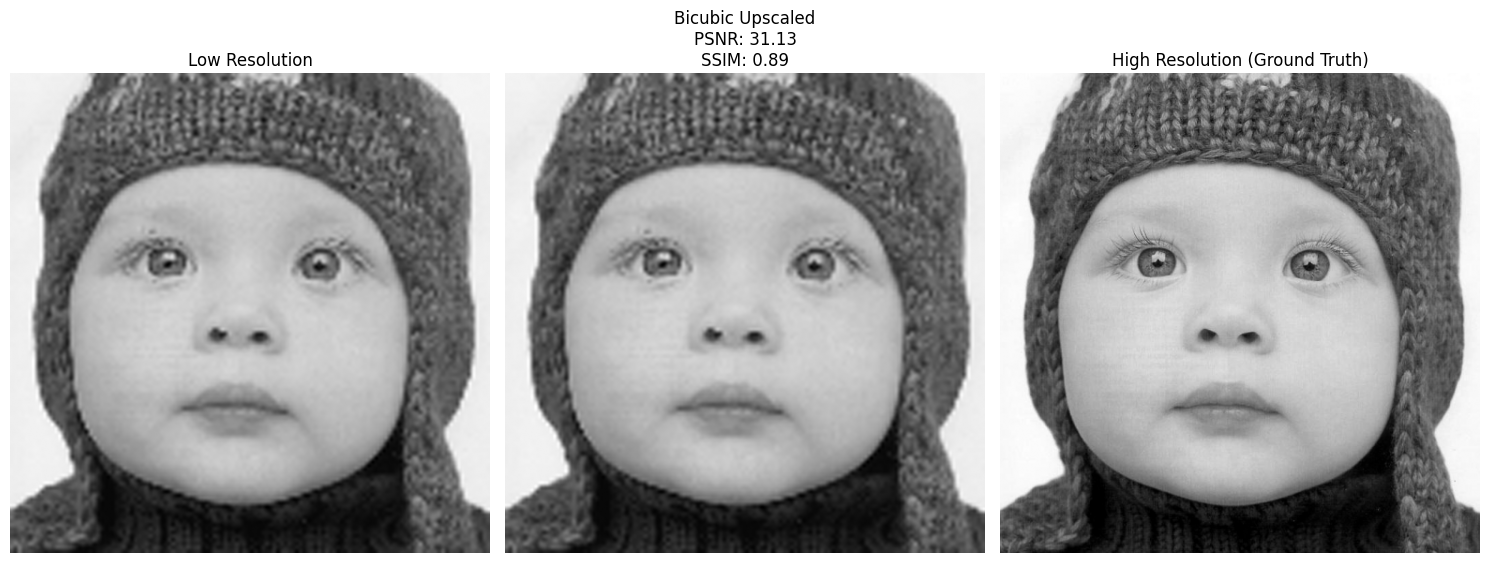

Batch 2 - Bicubic PSNR: 77.5734, Bicubic SSIM: 1.0000


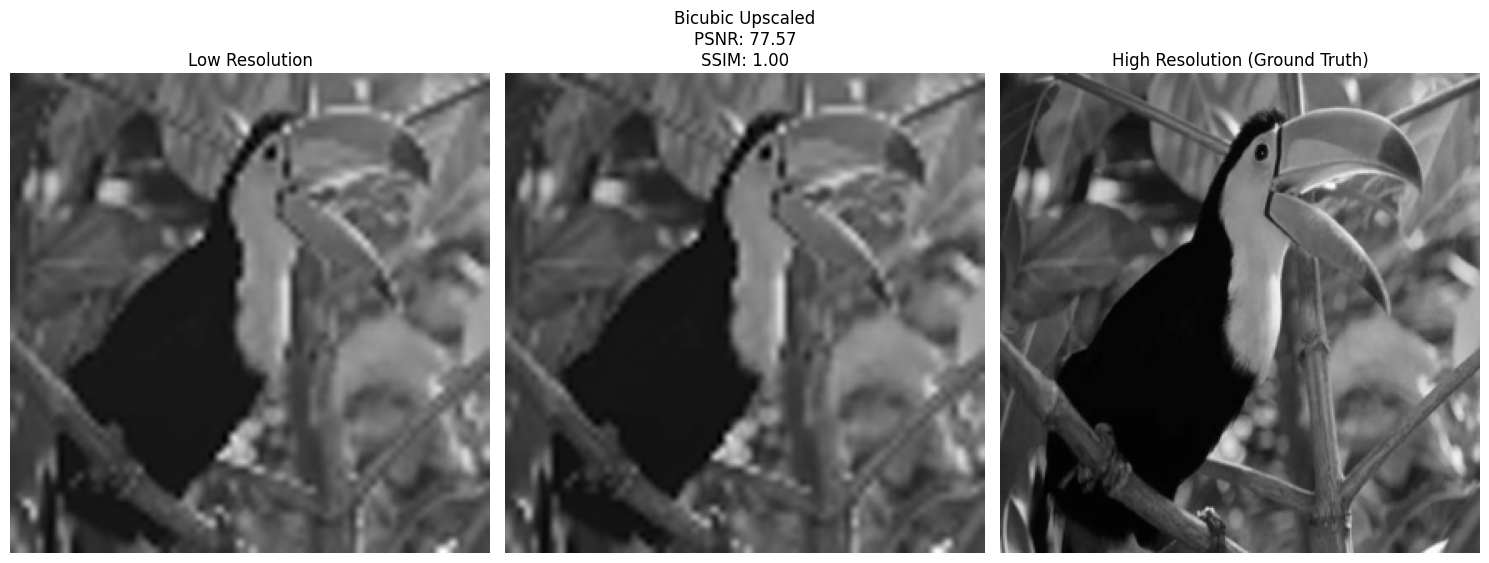

Batch 3 - Bicubic PSNR: 69.3649, Bicubic SSIM: 0.9998


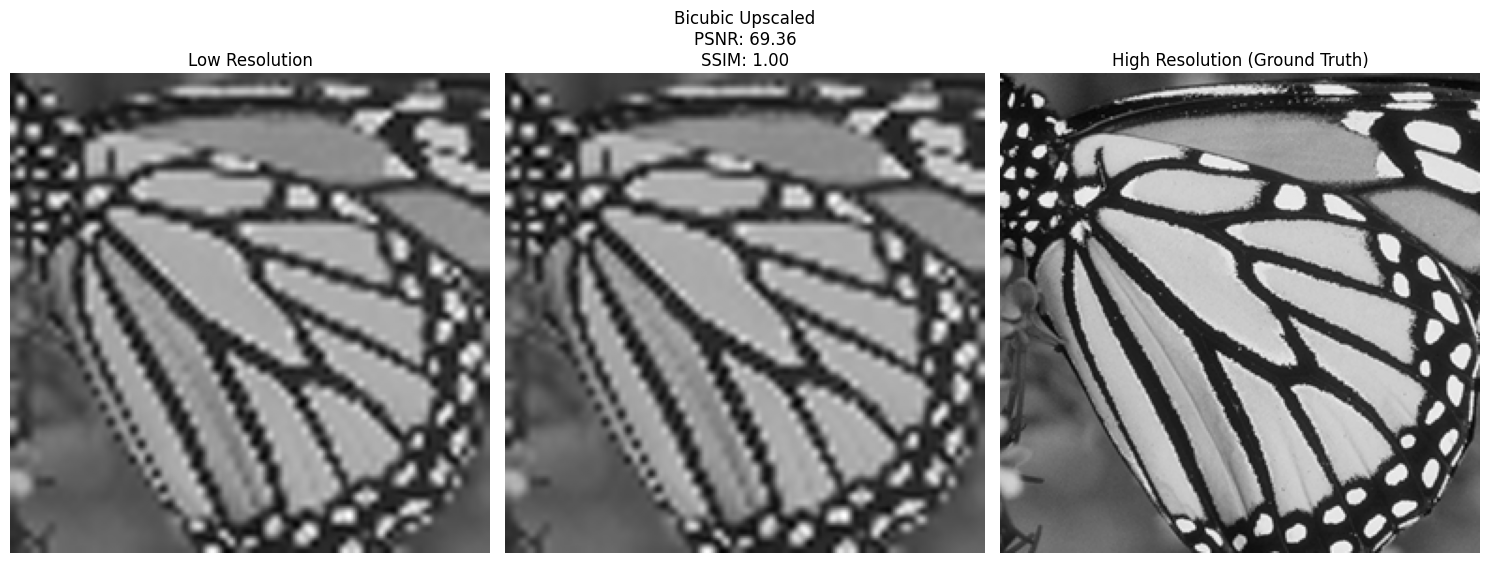

Batch 4 - Bicubic PSNR: 30.6362, Bicubic SSIM: 0.7889


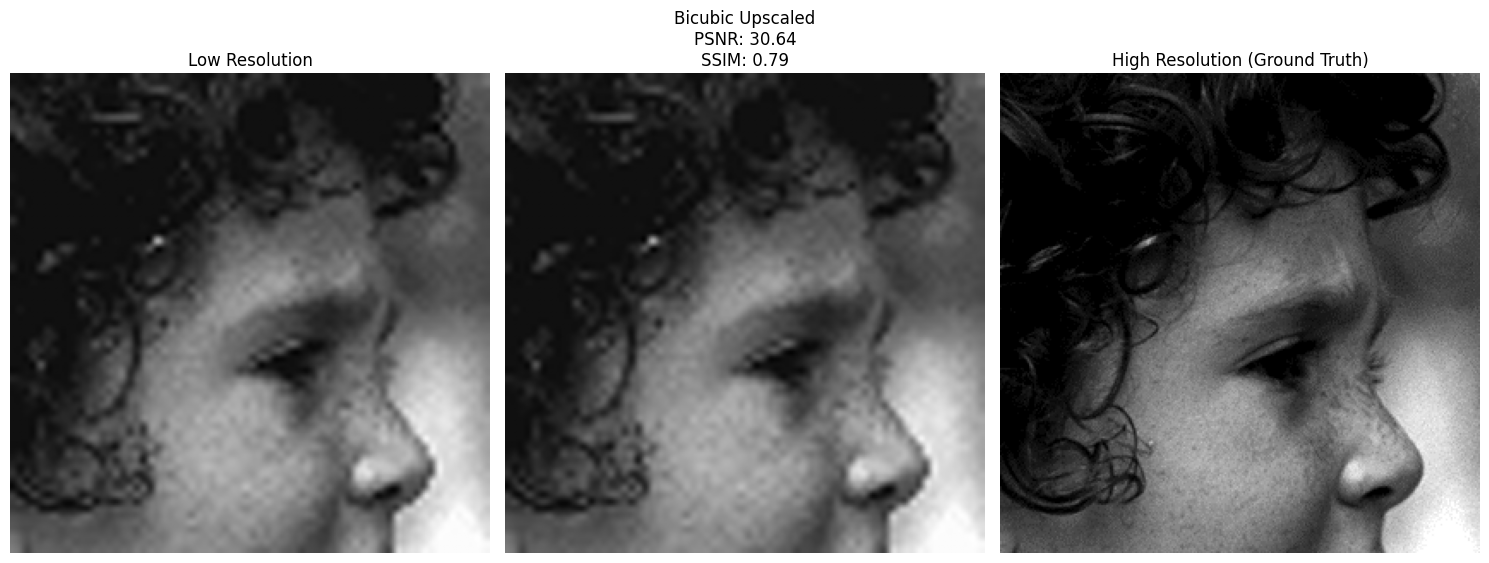

Batch 5 - Bicubic PSNR: 25.7424, Bicubic SSIM: 0.8693


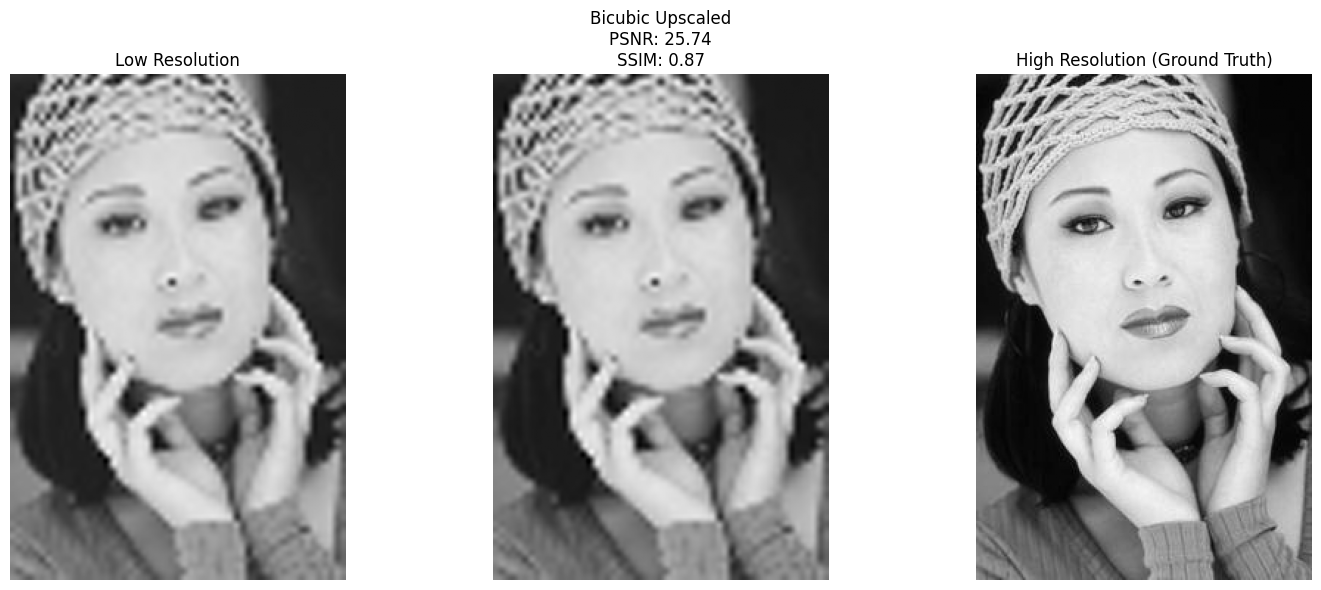


--- Overall Bicubic Upscaling Results ---
Average Bicubic PSNR: 46.8903
Average Bicubic SSIM: 0.9097


In [40]:
evaluate_bicubic_upscaling()

In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np # Import numpy for image manipulation

def evaluate_bicubic_upscaling():
    """
    Performs bicubic upscaling on validation set images, calculates
    PSNR and SSIM, and displays LR, Bicubic, and HR images side-by-side
    with metrics using OpenCV.
    """
    # Initialize PSNR and SSIM for evaluation
    # max_val is set to 1.0, assuming images are normalized to [0, 1] range.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    psnr_metric = PSNR(max_val=1.0).to(device)
    ssim_metric = SSIM(max_val=1.0).to(device)

    print("\n--- Starting Bicubic Upscaling Evaluation and Visualization (using OpenCV) ---")

    # Get valid_loader from your data preparation utility (as per your code)
    data_info = prepare_data()
    valid_loader = data_info["valid_loader"] # Using valid_loader as in your provided code

    bicubic_psnr_sum = 0.0
    bicubic_ssim_sum = 0.0
    num_test_samples = 0

    with torch.no_grad(): # Disable gradient calculation for evaluation
        for batch_idx, (lr_images, hr_images) in enumerate(valid_loader):
            # For visualization, we'll process only the first few batches
            # to avoid opening too many plot windows. Adjust as needed.
            if batch_idx >= 5: # Display images for first 5 batches, then break
                print("Displayed images for 5 batches. Continuing with metric calculation...")
                break # Break from the loop after displaying enough images
            
            # Skip batch if image reading failed (returned None)
            if lr_images is None or hr_images is None:
                print(f"Skipping batch {batch_idx+1} due to None images.")
                continue

            # Move images to the appropriate device
            lr_images = lr_images.to(device, non_blocking=True)
            hr_images = hr_images.to(device, non_blocking=True)

            # Ensure images are float and in [0, 1] range for consistent metric calculation and display.
            # This assumes your DataLoader might output images in [0, 255] if read by OpenCV.
            # If your DataLoader already normalizes to [0,1], you can remove this scaling.
            if lr_images.max() > 1.0:
                lr_images = lr_images / 255.0
                hr_images = hr_images / 255.0

            # Perform bicubic upscaling
            # The target size is taken from the ground truth HR image dimensions.
            bicubic_upscaled_images = F.interpolate(
                lr_images,
                size=(hr_images.shape[2], hr_images.shape[3]), # Target height and width
                mode='bicubic',
                align_corners=False # align_corners=False is generally recommended for image processing tasks
            )

            bicubic_upscaled_images = torch.clamp(bicubic_upscaled_images, 0.0, 1.0)

            # Calculate PSNR and SSIM for the current batch
            current_batch_psnr = psnr_metric(bicubic_upscaled_images, hr_images).item()
            current_batch_ssim = ssim_metric(bicubic_upscaled_images, hr_images).item()

            # Print per-batch results to console
            print(f"Batch {batch_idx+1} - Bicubic PSNR: {current_batch_psnr:.4f}, Bicubic SSIM: {current_batch_ssim:.4f}")

            # --- Prepare Images for OpenCV Display ---
            # Get the first image from the batch for visualization (assuming batch_size=1, or taking the first)
            # Move to CPU, remove the batch and channel dimensions (since SRCNN implies grayscale C=1),
            # and convert to [0, 255] uint8 for OpenCV display.
            lr_img_np = (lr_images[0].cpu().squeeze().numpy() * 255.0).astype(np.uint8)
            hr_img_np = (hr_images[0].cpu().squeeze().numpy() * 255.0).astype(np.uint8)
            bicubic_img_np = (bicubic_upscaled_images[0].cpu().squeeze().numpy() * 255.0).astype(np.uint8)

            # Resize the LR image to HR dimensions for visual side-by-side comparison
            # This is only for display, not part of the bicubic evaluation itself.
            lr_resized_for_display = cv2.resize(lr_img_np,
                                                (hr_img_np.shape[1], hr_img_np.shape[0]),
                                                interpolation=cv2.INTER_NEAREST) # Use nearest for LR to avoid blurring

            # Stack images horizontally: LR (resized) | Bicubic | HR
            combined_image = np.hstack((lr_resized_for_display, bicubic_img_np, hr_img_np))

            # Add a black band at the bottom of the combined image to place text on
            band_height = 50 # Height of the black band in pixels
            black_band = np.zeros((band_height, combined_image.shape[1]), dtype=np.uint8)
            combined_image_with_band = np.vstack((combined_image, black_band))

            # Define text properties
            text = f"PSNR: {current_batch_psnr:.2f} | SSIM: {current_batch_ssim:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_color = (255, 255, 255) # White color for grayscale image

            # Calculate text position to center it horizontally below the bicubic image
            text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
            # Center text below the middle image (Bicubic Upscaled)
            text_x = int(hr_img_np.shape[1] + (hr_img_np.shape[1] - text_size[0]) / 2)
            # Position text vertically in the black band
            text_y = combined_image.shape[0] + (band_height - text_size[1]) // 2 + text_size[1] # Adjust y to be within the band

            # Put text on the combined image
            cv2.putText(combined_image_with_band, text, (text_x, text_y),
                        font, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
            # Display the combined image in an OpenCV window
            window_name = f"Batch {batch_idx+1} | Low-Res | Bicubic | High-Res"
            cv2.imshow(window_name, combined_image_with_band)
            cv2.waitKey(0) # Wait indefinitely until a key is pressed to close the window
            cv2.destroyAllWindows() # Close all OpenCV windows

            # --- End Display Images ---

            # Accumulate sums for overall average
            bicubic_psnr_sum += current_batch_psnr * lr_images.size(0)
            bicubic_ssim_sum += current_batch_ssim * lr_images.size(0)
            num_test_samples += lr_images.size(0)

    # Calculate and print overall average results
    if num_test_samples > 0:
        avg_bicubic_psnr = bicubic_psnr_sum / num_test_samples
        avg_bicubic_ssim = bicubic_ssim_sum / num_test_samples
        print(f"\n--- Overall Bicubic Upscaling Results ---")
        print(f"Average Bicubic PSNR: {avg_bicubic_psnr:.4f}")
        print(f"Average Bicubic SSIM: {avg_bicubic_ssim:.4f}")
    else:
        print("No samples were processed for bicubic upscaling evaluation.")

# To run this evaluation and see the visualizations, call the function:
# evaluate_bicubic_upscaling()

In [27]:
evaluate_bicubic_upscaling()


--- Starting Bicubic Upscaling Evaluation and Visualization (using OpenCV) ---
Batch 1 - Bicubic PSNR: 77.9449, Bicubic SSIM: 1.0000
Batch 2 - Bicubic PSNR: 76.2867, Bicubic SSIM: 1.0000
Batch 3 - Bicubic PSNR: 68.0431, Bicubic SSIM: 0.9997
Batch 4 - Bicubic PSNR: 77.4554, Bicubic SSIM: 1.0000
Batch 5 - Bicubic PSNR: 24.4400, Bicubic SSIM: 0.8618

--- Overall Bicubic Upscaling Results ---
Average Bicubic PSNR: 64.8340
Average Bicubic SSIM: 0.9723


In [9]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Include your PSNR and SSIM class definitions here
# (You may paste the class definitions exactly as you provided in your message)

class PSNR(nn.Module):
    def __init__(self, max_val: float = 1.0, crop_border: int = 0):
        super().__init__()
        self.max_val = max_val
        self.crop_border = crop_border

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        if img1.shape != img2.shape:
            raise ValueError(f"Image shapes must match. Got {img1.shape} and {img2.shape}")
        if img1.device != img2.device:
            img2 = img2.to(img1.device)
        if self.crop_border > 0:
            img1 = img1[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]
            img2 = img2[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]
        mse = F.mse_loss(img1, img2, reduction='mean')
        if mse == 0:
            return torch.tensor(float('inf'))
        psnr = 10 * torch.log10(self.max_val ** 2 / mse)
        return psnr

class SSIM(nn.Module):
    def __init__(self, window_size: int = 11, channels: int = 1, max_val: float = 1.0, crop_border: int = 0):
        super().__init__()
        self.window_size = window_size
        self.channels = channels
        self.max_val = max_val
        self.crop_border = crop_border
        self.C1 = (0.01 * self.max_val) ** 2
        self.C2 = (0.03 * self.max_val) ** 2
        self.gaussian_window = self._create_gaussian_window(window_size, channels)

    def _create_gaussian_window(self, window_size, channels):
        _1D_gaussian = torch.exp(-(torch.arange(window_size, dtype=torch.float32) - window_size // 2).pow(2) / float(window_size // 2)**2 / 2)
        _1D_gaussian = _1D_gaussian / _1D_gaussian.sum()
        _2D_gaussian = _1D_gaussian.unsqueeze(0) * _1D_gaussian.unsqueeze(1)
        window = _2D_gaussian.expand(channels, 1, window_size, window_size).contiguous()
        return window

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        if img1.shape != img2.shape:
            raise ValueError(f"Image shapes must match. Got {img1.shape} and {img2.shape}")
        if img1.device != img2.device:
            img2 = img2.to(img1.device)
        window = self.gaussian_window.to(img1.device)
        if self.crop_border > 0:
            img1 = img1[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]
            img2 = img2[..., self.crop_border:-self.crop_border, self.crop_border:-self.crop_border]

        mu1 = F.conv2d(img1, window, padding=0, groups=self.channels, stride=1)
        mu2 = F.conv2d(img2, window, padding=0, groups=self.channels, stride=1)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=0, groups=self.channels, stride=1) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=0, groups=self.channels, stride=1) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=0, groups=self.channels, stride=1) - mu1_mu2

        numerator = (2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)
        denominator = (mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2)
        ssim_map = numerator / denominator
        return ssim_map.mean()

def preprocess_for_metrics(image_np: np.ndarray) -> torch.Tensor:
    """Convert a NumPy image [H, W] or [H, W, 1] in [0,255] to PyTorch tensor [1,1,H,W] in [0,1]"""
    if image_np.ndim == 3:
        image_np = image_np[..., 0]  # Convert to single channel if needed
    image_np = image_np.astype(np.float32) / 255.0
    tensor = torch.from_numpy(image_np).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    return tensor

def main():

    data_folder= r"C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5"
    image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # data_file = r"C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\woman.png"
    total_psnr_value= 0.0
    total_ssim_value = 0.0
    for i in range(len(image_files)):
        data_file = image_files[i]
        print(f"Processing image: {data_file}")
        
        original = cv2.imread(data_file)
        if original is None:
            print(f"Error: Could not load image from {data_file}. Please check the path.")
            return

        h, w = original.shape[:2]
        scale_factor = 4

        original_y = cv2.cvtColor(original, cv2.COLOR_BGR2YCrCb)[:, :, 0]

        # Downscale and upscale to simulate bicubic upscaling
        compressed = cv2.resize(original, (w // scale_factor, h // scale_factor), interpolation=cv2.INTER_CUBIC)
        compressed = cv2.resize(compressed, (w, h), interpolation=cv2.INTER_CUBIC)
        compressed_y = cv2.cvtColor(compressed, cv2.COLOR_BGR2YCrCb)[:, :, 0]

        # Convert to torch tensors in [0,1] for metric calculation
        original_tensor = preprocess_for_metrics(original_y)
        compressed_tensor = preprocess_for_metrics(compressed_y)

        # Instantiate metrics
        psnr_metric = PSNR()
        ssim_metric = SSIM()

        # Compute metrics
        psnr_val = psnr_metric(original_tensor, compressed_tensor).item()
        ssim_val = ssim_metric(original_tensor, compressed_tensor).item()

        total_psnr_value += psnr_val
        total_ssim_value += ssim_val

        print(f"PSNR value for bicubic upscaling: {psnr_val:.2f} dB")
        print(f"SSIM value for bicubic upscaling: {ssim_val:.4f}")

        # Optional display
        cv2.imshow("Original Image", original)
        cv2.imshow("Bicubic Upscaled Image", compressed)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    average_psnr = total_psnr_value / len(image_files)
    average_ssim = total_ssim_value / len(image_files)
    print(f"Average PSNR value for bicubic upscaling: {average_psnr:.2f} dB")
    print(f"Average SSIM value for bicubic upscaling: {average_ssim:.4f}")

if __name__ == "__main__":
    main()


Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\baby.png
PSNR value for bicubic upscaling: 29.82 dB
SSIM value for bicubic upscaling: 0.8793
Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\bird.png
PSNR value for bicubic upscaling: 28.17 dB
SSIM value for bicubic upscaling: 0.9030
Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\butterfly.png
PSNR value for bicubic upscaling: 19.95 dB
SSIM value for bicubic upscaling: 0.8051
Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\head.png
PSNR value for bicubic upscaling: 29.32 dB
SSIM value for bicubic upscaling: 0.7662
Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\woman.png
PSNR value for bicubic upscaling: 24.46 dB
SSIM value for bicubic upscaling: 0.8621
Average PSNR v

In [15]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from src.utils.metrics import PSNR, SSIM # Assuming PSNR and SSIM are here
from src.utils.models.SRCNN import SRCNN

def preprocess_for_metrics(image_np: np.ndarray) -> torch.Tensor:
    if image_np.ndim == 3:
        image_np = image_np[..., 0]  # Ensure single channel
    image_np = image_np.astype(np.float32) / 255.0
    tensor = torch.from_numpy(image_np).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    return tensor
def plot_and_save_results(bicubic_color, model_output_color, original_color, index, out_dir, psnr_bicubic, ssim_bicubic, psnr_model, ssim_model):
    """
    Save a 3-image comparison: Bicubic vs SRCNN vs Original (all in color)
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(cv2.cvtColor(bicubic_color, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Bicubic\nPSNR: {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}")

    axs[1].imshow(cv2.cvtColor(model_output_color, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"SRCNN Output\nPSNR: {psnr_model:.2f}, SSIM: {ssim_model:.4f}")

    axs[2].imshow(cv2.cvtColor(original_color, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Original HR")

    for ax in axs:
        ax.axis("off")

    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, f"comparison_{index+1}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
def main():
    data_folder = r"C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5"
    save_dir = os.path.join(r"C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\results\evaluates")
    model_path = r'results\models\SRCNN_v1_20250721_224623\SRCNN_model.pth'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    psnr_metric = PSNR().to(device)
    ssim_metric = SSIM().to(device)

    total_psnr_value = 0.0
    total_ssim_value = 0.0
    model = SRCNN().to(device)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    start_time = time.time()
    for i, data_file in enumerate(image_files):
        print(f"\nProcessing image: {data_file}")
        image_start = time.time()

        original = cv2.imread(data_file)
        if original is None:
            print(f"Error loading image: {data_file}")
            continue

        h, w = original.shape[:2]
        scale_factor = 4

        ycbcr = cv2.cvtColor(original, cv2.COLOR_BGR2YCrCb)
        original_y, original_cb, original_cr = ycbcr[:, :, 0], ycbcr[:, :, 1], ycbcr[:, :, 2]

        # Downscale and then bicubic upscale
        downscaled = cv2.resize(original, (w // scale_factor, h // scale_factor), interpolation=cv2.INTER_CUBIC)
        bicubic_upscaled = cv2.resize(downscaled, (w, h), interpolation=cv2.INTER_CUBIC)

        bicubic_ycbcr = cv2.cvtColor(bicubic_upscaled, cv2.COLOR_BGR2YCrCb)
        bicubic_y = bicubic_ycbcr[:, :, 0]

        # Tensors
        original_y_tensor = preprocess_for_metrics(original_y).to(device)
        bicubic_y_tensor = preprocess_for_metrics(bicubic_y).to(device)

        # SRCNN output
        with torch.no_grad():
            model_output_tensor = model(bicubic_y_tensor)

        # PSNR & SSIM
        psnr_bicubic = psnr_metric(bicubic_y_tensor, original_y_tensor).item()
        ssim_bicubic = ssim_metric(bicubic_y_tensor, original_y_tensor).item()
        psnr_model = psnr_metric(model_output_tensor, original_y_tensor).item()
        ssim_model = ssim_metric(model_output_tensor, original_y_tensor).item()

        print(f"PSNR (Bicubic): {psnr_bicubic:.2f}, SSIM: {ssim_bicubic:.4f}")
        print(f"PSNR (SRCNN):  {psnr_model:.2f}, SSIM: {ssim_model:.4f}")
        print(f"Image evaluation time: {time.time() - image_start:.2f}s")

        total_psnr_value += psnr_model
        total_ssim_value += ssim_model

        # Recover full-color images
        model_output_np = (model_output_tensor.squeeze().cpu().numpy() * 255.0).clip(0, 255).astype(np.uint8)
        model_output_ycbcr = cv2.merge([model_output_np, original_cb, original_cr])
        model_output_bgr = cv2.cvtColor(model_output_ycbcr, cv2.COLOR_YCrCb2BGR)

        # Save comparison image
        plot_and_save_results(
            bicubic_color=bicubic_upscaled,
            model_output_color=model_output_bgr,
            original_color=original,
            index=i,
            out_dir=save_dir,
            psnr_bicubic=psnr_bicubic,
            ssim_bicubic=ssim_bicubic,
            psnr_model=psnr_model,
            ssim_model=ssim_model
        )

    total_time = time.time() - start_time
    average_psnr = total_psnr_value / len(image_files)
    average_ssim = total_ssim_value / len(image_files)
    print(f"\nAverage PSNR (SRCNN): {average_psnr:.2f} dB")
    print(f"Average SSIM (SRCNN): {average_ssim:.4f}")
    print(f"Total evaluation time: {total_time:.2f}s")


if __name__ == "__main__":
    main()



Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\baby.png
PSNR (Bicubic): 29.82, SSIM: 0.8793
PSNR (SRCNN):  27.19, SSIM: 0.8351
Image evaluation time: 0.03s

Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\bird.png
PSNR (Bicubic): 28.17, SSIM: 0.9030
PSNR (SRCNN):  25.85, SSIM: 0.8141
Image evaluation time: 0.01s

Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\butterfly.png
PSNR (Bicubic): 19.95, SSIM: 0.8051
PSNR (SRCNN):  19.76, SSIM: 0.7853
Image evaluation time: 0.01s

Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\head.png
PSNR (Bicubic): 29.32, SSIM: 0.7662
PSNR (SRCNN):  26.07, SSIM: 0.6412
Image evaluation time: 0.01s

Processing image: C:\Users\User\Desktop\Works\Github_repo\pytorch-image-super-resolution\data\raw\Set5\woman.png
PSNR (Bicubic): 24.46, SSIM: 

In [20]:
for name, param in model.named_parameters():
    print(f"{name:30s} | shape: {tuple(param.shape)} | requires_grad: {param.requires_grad}")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")


conv1.weight                   | shape: (64, 1, 9, 9) | requires_grad: True
conv1.bias                     | shape: (64,) | requires_grad: True
conv2.weight                   | shape: (32, 64, 1, 1) | requires_grad: True
conv2.bias                     | shape: (32,) | requires_grad: True
conv3.weight                   | shape: (1, 32, 5, 5) | requires_grad: True
conv3.bias                     | shape: (1,) | requires_grad: True
Total parameters: 8,129
Trainable parameters: 8,129


In [18]:
model = SRCNN()